In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy

if not 'have_changed_cwd' in globals():
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
    os.chdir(PROJECT_ROOT)
    have_changed_cwd = True
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/mat/Desktop/Files/Code/Hopfield


## Hebbian Learning

In [18]:
from turtle import right
from src.learning.classifier import HopfieldClassifier
from src.multi_net.logging import EnsembleLogger
from src.network.ensemble import HopfieldEnsemble
from src.network.initializer import AsymmetricCoupling, binary_spin_state_sampler
from src.network.logging import HopfieldLogger
from src.network.network import HopfieldNetwork
from src.multi_net.plotting import ReplicatedPlotter
import numpy as np


seed = 42
N = 1000
y = 5
k = 1.6
J_D = 0.3
chained = True
symmetric = False
h = 2.0
log_interval = 1000
check_convergence_interval = 1000
state_initializer = binary_spin_state_sampler


rng = np.random.default_rng(seed)
coupling_initializer = (
    SymmetricCoupling(mean=0.0, std=1.0)
    if symmetric
    else AsymmetricCoupling(mean=0.0, std=1.0)
)
networks = [
    HopfieldNetwork(
        N=N,
        coupling_initializer=coupling_initializer,
        state_initializer=state_initializer,
        J_D=J_D,
        rng=rng,
    )
    for _ in range(y)
]
loggers = [HopfieldLogger(reference_state=net.state) for net in networks]
similarities_logger = EnsembleLogger()
ensemble = HopfieldEnsemble(networks, k, chained, None, None, h=h)

model = HopfieldClassifier(
    ensemble=ensemble,
    loggers=loggers,
    ensemble_logger=similarities_logger,
    log_interval=log_interval,
    check_convergence_interval=check_convergence_interval,
)

input = np.sign(np.random.randn(N)).astype(int)
label = np.sign(np.random.randn(N)).astype(int)
label_step_interval = 3
initial_guess = np.sign(np.random.randn(N)).astype(int)
num_steps = 10 # hebb

In [19]:
def plot(simulation):
    plotter = ReplicatedPlotter(simulation.loggers, simulation.ensemble_logger)

    fig1 = plotter.plot_all_metrics()
    plt.show()

  5%|▌         | 54000/1000000 [00:03<01:04, 14590.25it/s]


0.49


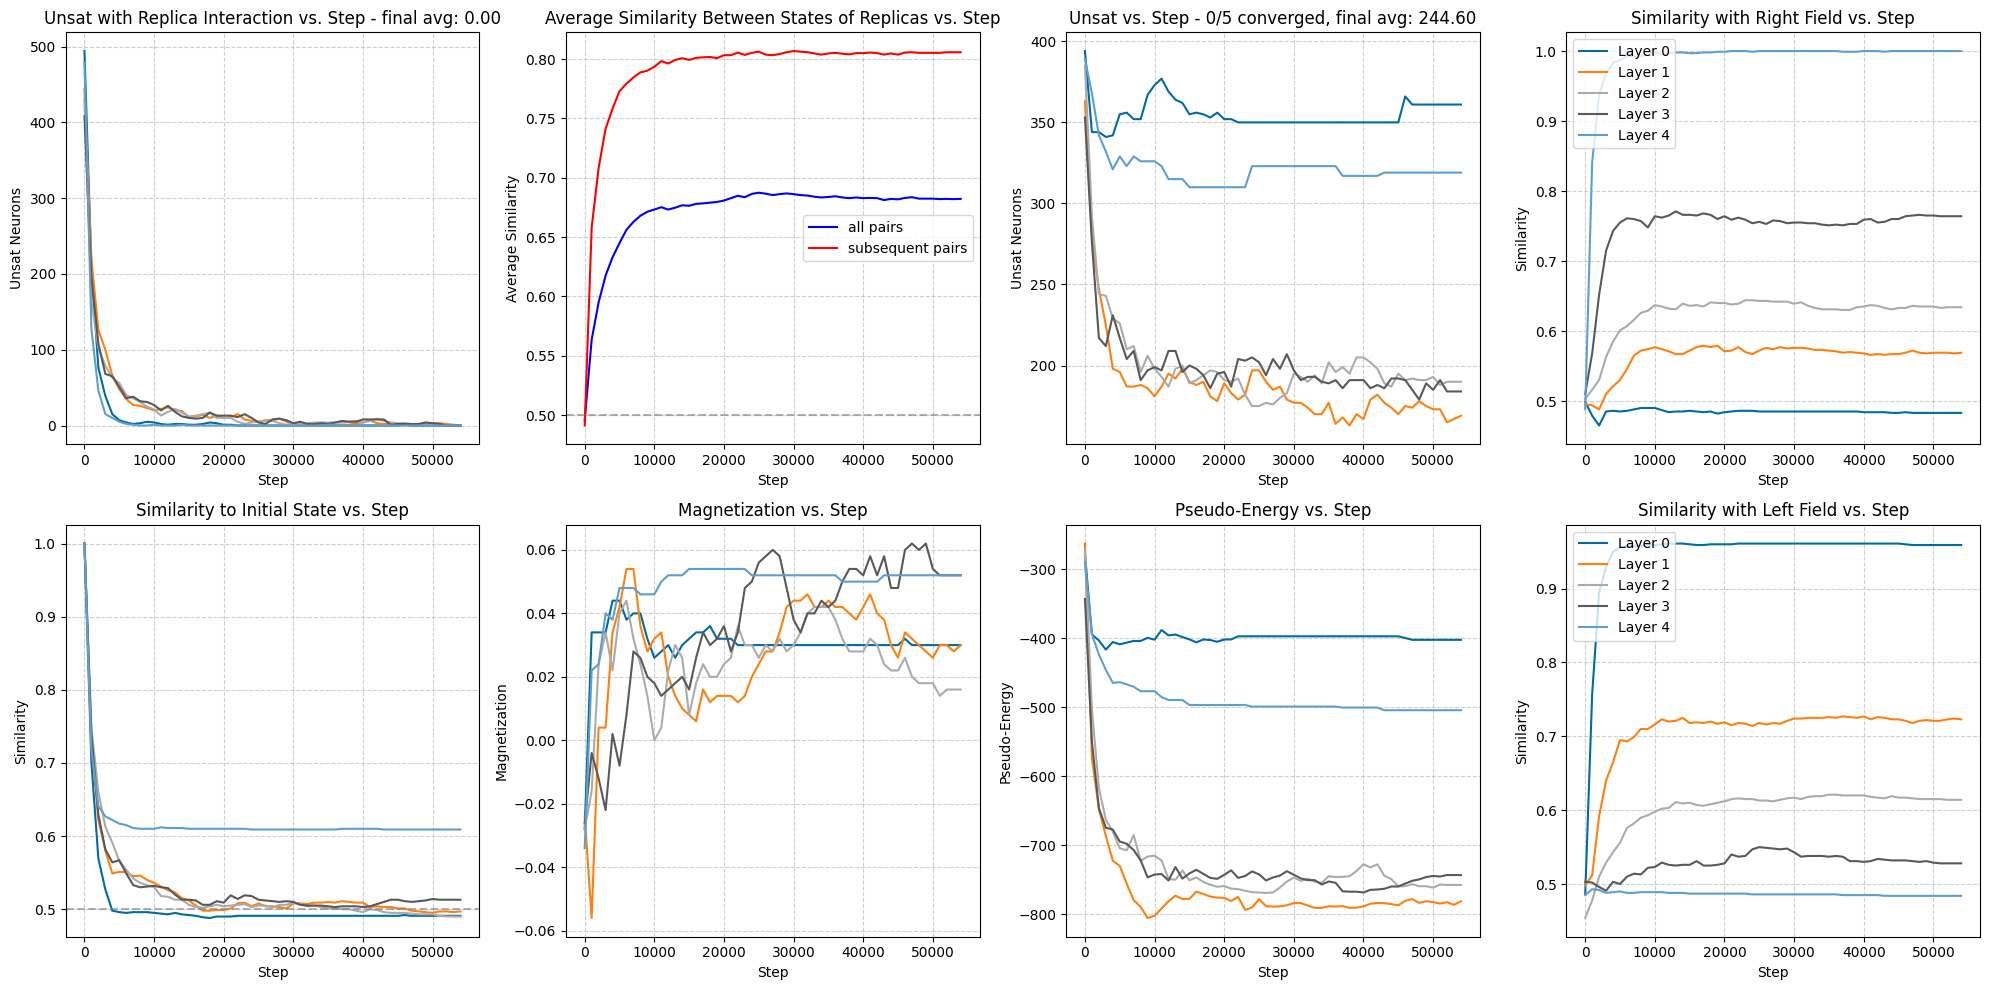

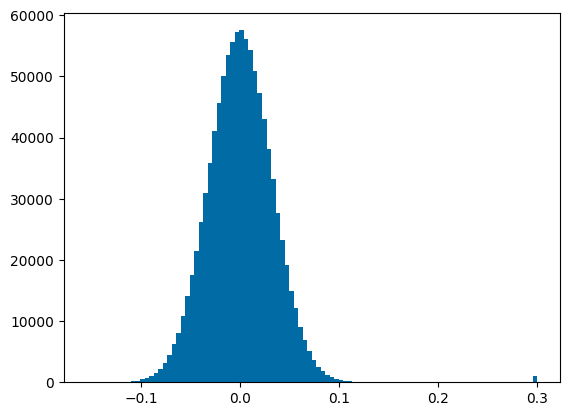

In [20]:
p0, converged = model.predict(input, 1000000, rng, label_step_interval=label_step_interval, initial_guess=initial_guess)
b0 = copy.deepcopy(model.ensemble)
print((p0 == label).sum() / N)
plot(model)
model.reset_state_and_loggers()
plt.hist(model.networks[0].J.flatten(), bins=100)
plt.show()

  1%|          | 8000/1000000 [00:00<01:09, 14333.47it/s]


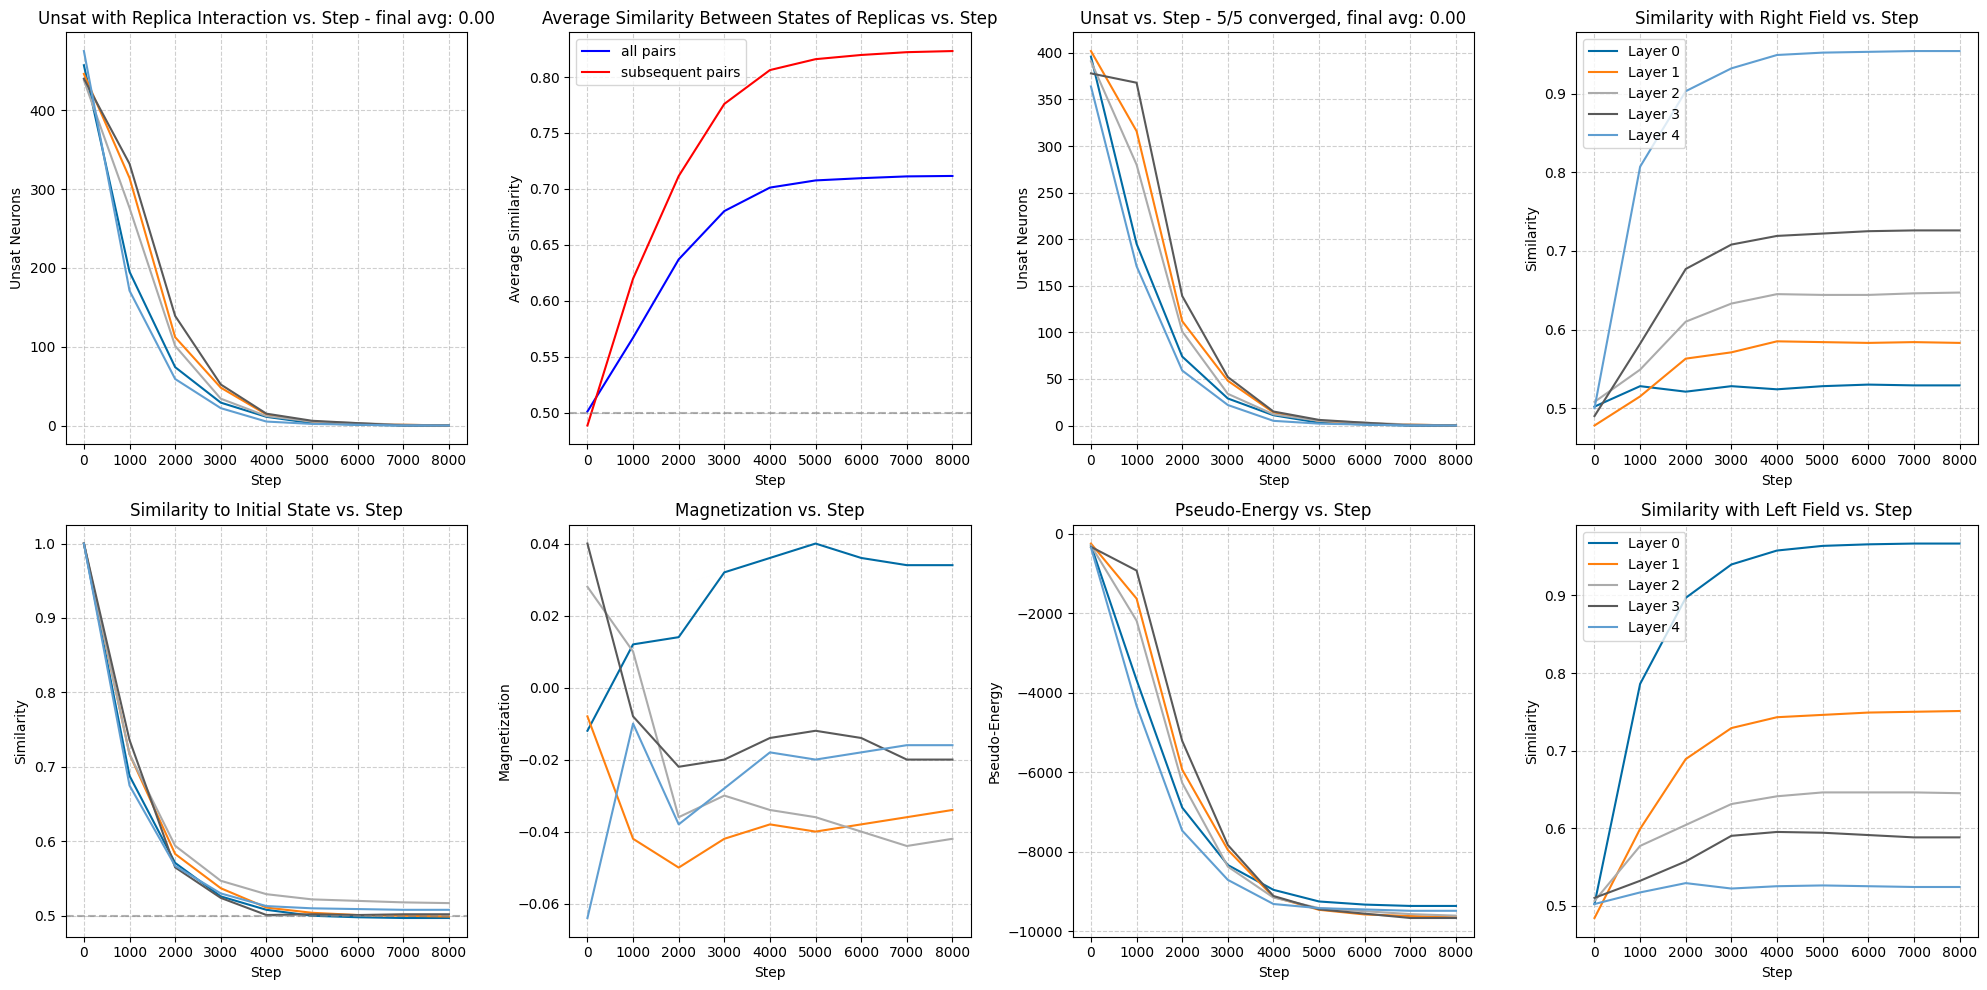

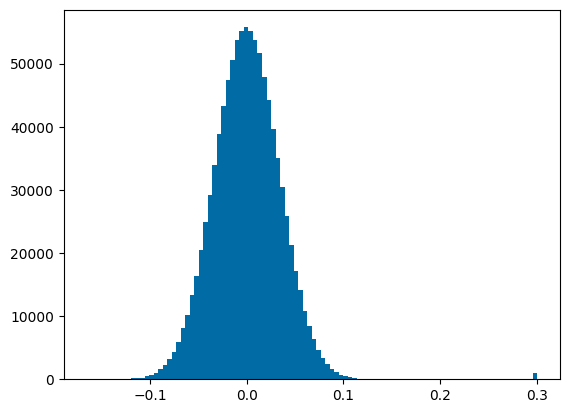

In [21]:
for i in range(num_steps):
    model.train_step_hebb(input, label, 0.001, 1000000, rng)
    b1 = copy.deepcopy(model.ensemble)
    if i == num_steps-1:
        plot(model)
    model.reset_state_and_loggers()
plt.hist(model.networks[0].J.flatten(), bins=100)
plt.show()

  2%|▎         | 25000/1000000 [00:01<01:06, 14608.14it/s]


0.046


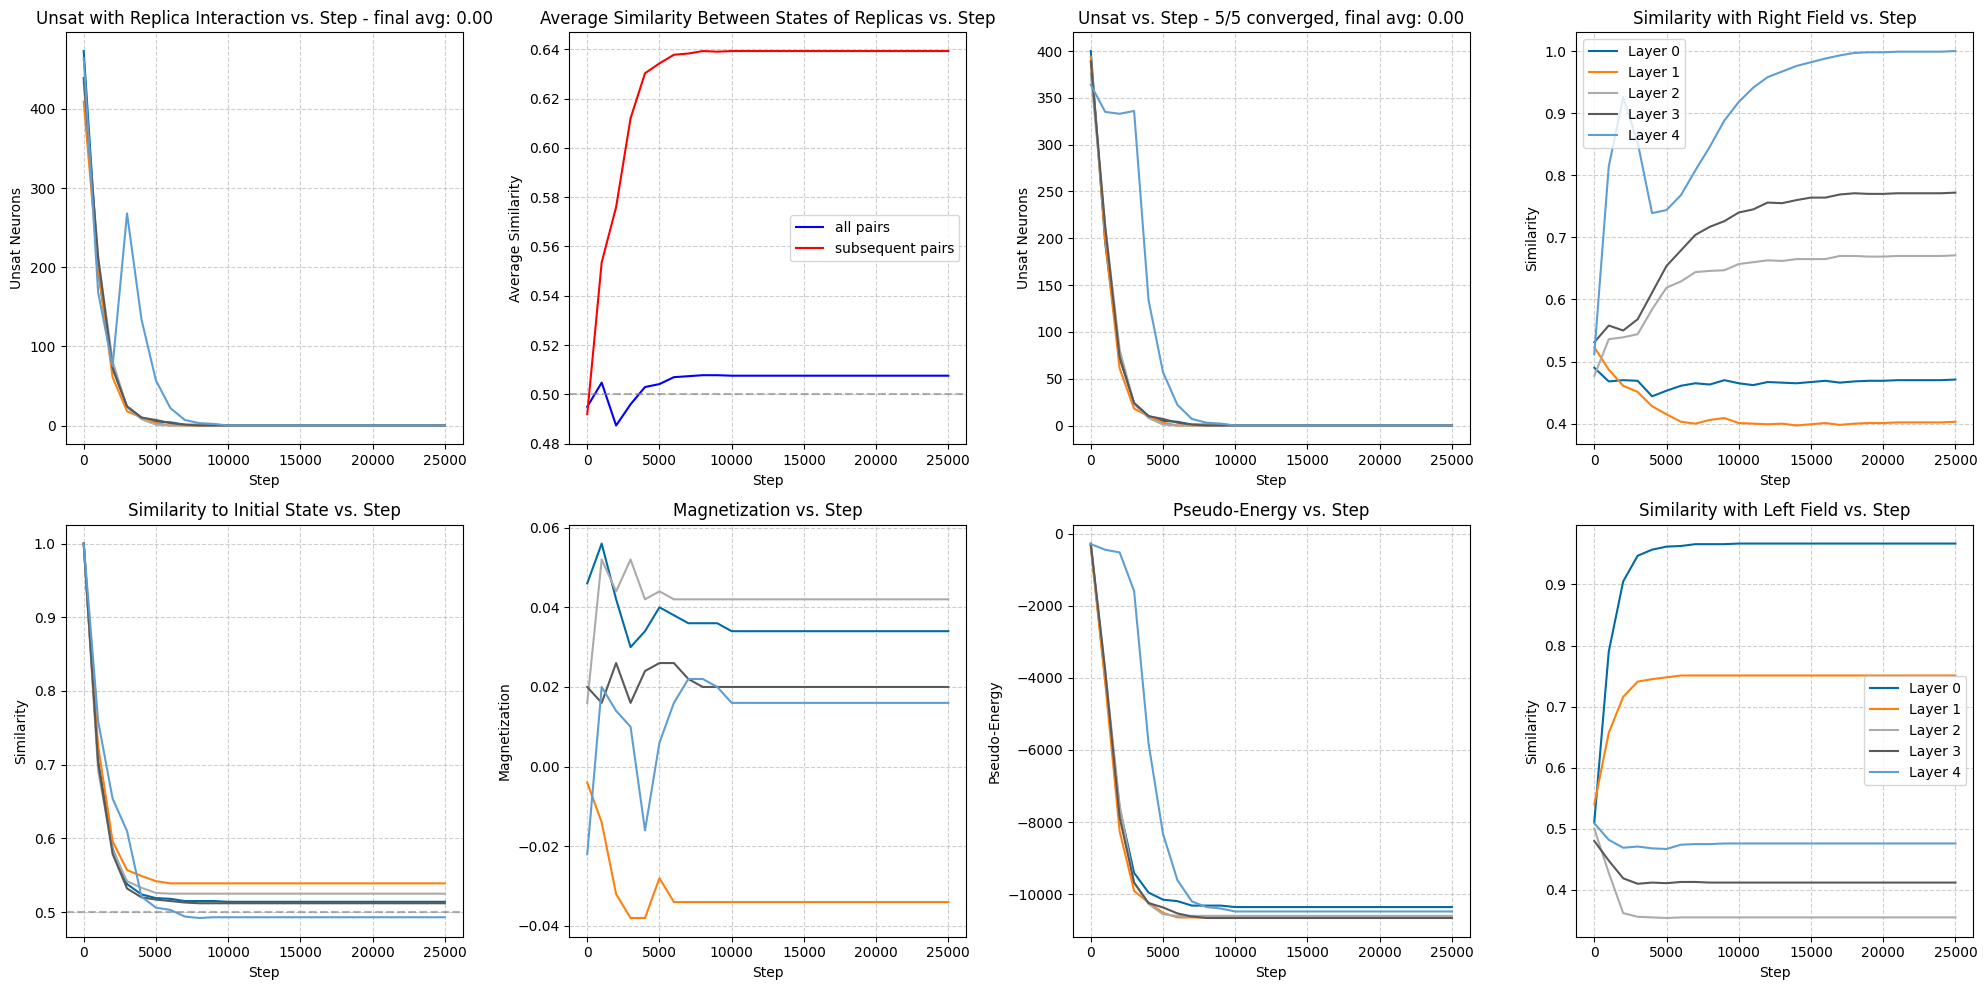

In [22]:
p2, converged = model.predict(input, 1000000, rng, label_step_interval=label_step_interval, initial_guess=initial_guess)
print((p2 == label).sum() / N)
b2 = copy.deepcopy(model.ensemble)
plot(model)
model.reset_state_and_loggers()

In [23]:
print(f"Similarity between initial prediction and label: {(p0 == label).mean():.2f}")
print(f"Similarity between trained prediction and label: {(p2 == label).mean():.2f}")
print(f"Similarity between initial prediction and initial condition of inference: {(p0 == initial_guess).mean():.2f}")
print(f"Similarity between trained prediction and initial condition of inference: {(p2 == initial_guess).mean():.2f}")

Similarity between initial prediction and label: 0.49
Similarity between trained prediction and label: 0.05
Similarity between initial prediction and initial condition of inference: 0.84
Similarity between trained prediction and initial condition of inference: 0.53


In [24]:
print("Similarity between initial and trained internal representations (layer-wise):")
print([f"{b0.networks[i].state_similarity(b2.networks[i].state):.2f}" for i in range(y)])

Similarity between initial and trained internal representations (layer-wise):
['0.95', '0.67', '0.45', '0.51', '0.52']


In [25]:
print("Similarity between trained representations and the representations used for hebbian step:")
print([f"{b2.networks[i].state_similarity(b1.networks[i].state):.2f}" for i in range(y)])

Similarity between trained representations and the representations used for hebbian step:
['1.00', '1.00', '0.00', '0.00', '0.00']


In [ ]:
# ## Single Network dynamics
# from src.hopfield.dynamics import AsynchronousDeterministicUpdate
# from src.hopfield.initializer import SymmetricCoupling, random_sampler
# from src.hopfield.logger import Logger
# from src.hopfield.network import HopfieldNetwork
# from src.hopfield.plotter import HopfieldPlotter
# from src.hopfield.simulation import HopfieldSimulation
# from src.hopfield.stopping import SimpleStoppingCondition
# from scripts.main import main


# network, logger, plotter, metrics_fig, hist_fig = main()
# plt.show()
# network.analyze_stability(1, 10, 3, dynamics=AsynchronousDeterministicUpdate())